In [ ]:
import torch
import torchvision
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
import time
from sklearn.model_selection import KFold
from torchvision import models
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224,224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualizing Some Images


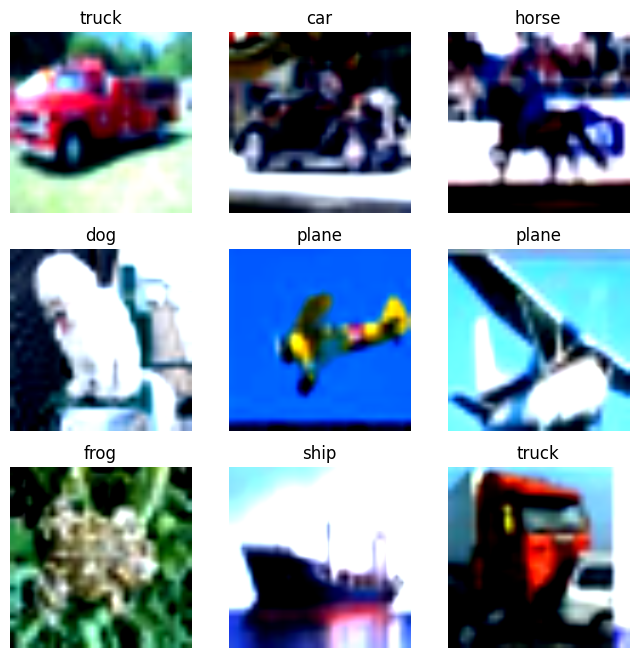

In [ ]:
# Following code is inspired from
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# provided along with the assignment description

labels_dict = {
    0:'plane',
    1:'car',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_dict[label])
    plt.axis("off")
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.squeeze(), (1, 2, 0)), cmap="gray")
plt.show()

In [ ]:
trainset[0][0].shape

torch.Size([3, 224, 224])

# Section I: Select Best Deep Learning Model


# Setting Some Parameters to be common accross training

In [ ]:
num_classes = 10
num_epochs = 5
num_splits = 5

# K Fold 80:20 Split Check

In [ ]:
kf = KFold(n_splits=num_splits)
for f, (train_index, val_index) in enumerate(kf.split(trainset)):
    print(f'Fold:{f}, Train set: {len(train_index)}, Val set:{len(val_index)}')

Fold:0, Train set: 40000, Val set:10000
Fold:1, Train set: 40000, Val set:10000
Fold:2, Train set: 40000, Val set:10000
Fold:3, Train set: 40000, Val set:10000
Fold:4, Train set: 40000, Val set:10000


# MobileNet V3 Small

In [ ]:
train_data = trainset
test_data = testset
kf = KFold(n_splits=num_splits)
best_model_acc_so_far = 0
for f, (train_index, val_index) in enumerate(kf.split(trainset)):
  start = time.time()
  print("#"*50+" Fold "+str(f)+" "+"#"*50)
  trainsubset = torch.utils.data.Subset(train_data, train_index)
  valsubset = torch.utils.data.Subset(train_data, val_index)

  model = models.mobilenet_v3_small(weights=None, num_classes=num_classes)
  loss_fn = nn.CrossEntropyLoss()

  # Following Parameters are overridden in some folds
  # to simulate different training on model
  # to pick from best fold
  batch_size=32
  if f==0:
    lr = 0.0001
  elif f==1:
    lr = 0.0003
  elif f==2:
    lr = 0.001
  elif f==3:
    batch_size = 128
  elif f==4:
    batch_size = 256

  optimizer = optim.Adam(model.parameters(), lr=lr)

  trainloader = torch.utils.data.DataLoader(trainsubset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
  valloader = torch.utils.data.DataLoader(valsubset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

  epoch_train_loss = []
  epoch_train_acc = []
  epoch_val_loss = []
  epoch_val_acc = []
  model.to(device)
  for epoch in range(num_epochs):
    print("+"*50+" Epoch "+str(epoch)+" "+"+"*50)
    running_loss = 0.0
    running_corrects = 0
    model.train()
    for i, data in enumerate(trainloader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      _,preds = torch.max(outputs, 1)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()*inputs.size(0)
      running_corrects += torch.sum(labels==preds).item()
    train_loss = running_loss/len(trainloader.sampler)
    train_acc = running_corrects/len(trainloader.sampler)
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_acc)
    val_loss = 0
    val_acc = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(valloader):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = loss_fn(outputs,labels)
          _,preds = torch.max(outputs, 1)
          val_loss += loss.item()*inputs.size(0)
          val_acc += torch.sum(labels==preds).item()

        val_loss = val_loss/len(valloader.sampler)
        val_acc = val_acc/len(valloader.sampler)
        epoch_val_loss.append(val_loss)
        epoch_val_acc.append(val_acc)
    print('Training: Loss: {} Accuracy: {}'.format(train_loss, train_acc))
    print('Vaidation: Loss: {} Accuracy: {}'.format(val_loss, val_acc))

  end = time.time()
  train_time = end-start
  val_loss = 0
  val_acc = 0
  model.eval()
  with torch.no_grad():
    for i, data in enumerate(valloader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs,labels)
      _,preds = torch.max(outputs, 1)
      val_loss += loss.item()*inputs.size(0)
      val_acc += torch.sum(labels==preds).item()
    val_loss = val_loss/len(valloader.sampler)
    val_acc = val_acc/len(valloader.sampler)
  print('Fold {} Validation Accuracy: {}'.format(f,val_acc))
  if best_model_acc_so_far < val_acc:
    best_model_acc_so_far = val_acc
    best_model_train_loss = epoch_train_loss
    best_model_train_acc = epoch_train_acc
    best_model_val_loss = epoch_val_loss
    best_model_val_acc = epoch_val_acc
    best_model_fold = f
    best_model_train_time = train_time
    torch.save(model, 'mobilenetv3_small_best.pt')

################################################## Fold 0 ##################################################
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 0 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 1.6335656358242034 Accuracy: 0.38035
Vaidation: Loss: 1.3933026184082031 Accuracy: 0.4825
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 1 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 1.2647609355449676 Accuracy: 0.54005
Vaidation: Loss: 1.1312736946105957 Accuracy: 0.592
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 2 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 1.0610335038661958 Accuracy: 0.619125
Vaidation: Loss: 1.0050079250335693 Accuracy: 0.6372
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 3 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 0.9141686087369919 Accuracy: 0.67295
Vaidation: Loss: 0.9623084726333618 Accuracy: 0.6553
+++++++++++++++++++++++++++

In [ ]:
print("Best Fold: ",best_model_fold)
print("Best Model Val Accuracy: ",best_model_acc_so_far)
print("Best Model Train Time in seconds: ",best_model_train_time)

Best Fold:  2
Best Model Val Accuracy:  0.7861
Best Model Train Time in seconds:  601.4772815704346


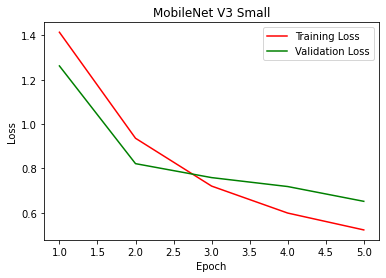

In [ ]:
# Loss Curve for Best Model
plt.plot(list(range(1,len(best_model_train_loss)+1)), best_model_train_loss, c='r', label='Training Loss')
plt.plot(list(range(1,len(best_model_val_loss)+1)), best_model_val_loss, c='g', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MobileNet V3 Small')
plt.legend()
plt.show()

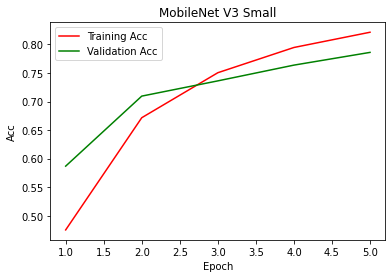

In [ ]:
# Accuracy Curve for Best Model
plt.plot(list(range(1,len(best_model_train_acc)+1)), best_model_train_acc, c='r', label='Training Acc')
plt.plot(list(range(1,len(best_model_val_acc)+1)), best_model_val_acc, c='g', label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('MobileNet V3 Small')
plt.legend()
plt.show()

In [ ]:
#test accuracy here
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)
y_true = []
y_pred = []
correct = 0
total = 0
# load best model during K-Fold
model = torch.load('mobilenetv3_small_best.pt')
model.to(device)
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_true = y_true + labels.detach().numpy().tolist()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        y_pred = y_pred + predicted.to('cpu').detach().numpy().tolist()
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 78 %


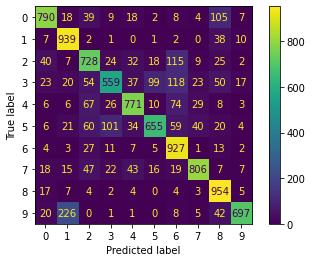

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
# Following code has been taken from pytorch forum
# and modified for getting number of parameters as well
# https://discuss.pytorch.org/t/finding-model-size/130275
param_size = 0
num_params = 0
for param in model.parameters():
  num_params += param.nelement()
  param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
  buffer_size += buffer.nelement() * buffer.element_size()
size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))
print('model params: {}'.format(num_params))

model size: 5.876MB
model params: 1528106


# SqueezeNet 1_1

In [ ]:
train_data = trainset
test_data = testset
kf = KFold(n_splits=num_splits)
best_model_acc_so_far = 0
for f, (train_index, val_index) in enumerate(kf.split(trainset)):
  start = time.time()
  print("#"*50+" Fold "+str(f)+" "+"#"*50)
  trainsubset = torch.utils.data.Subset(train_data, train_index)
  valsubset = torch.utils.data.Subset(train_data, val_index)

  model = models.squeezenet1_1(weights=None, num_classes=num_classes)
  loss_fn = nn.CrossEntropyLoss()

  # Following Parameters are overridden in some folds
  # to simulate different training on model
  # to pick from best fold
  batch_size=32
  if f==0:
    lr = 0.0001
  elif f==1:
    lr = 0.0003
  elif f==2:
    lr = 0.001
  elif f==3:
    batch_size = 128
  elif f==4:
    batch_size = 256

  optimizer = optim.Adam(model.parameters(), lr=lr)

  trainloader = torch.utils.data.DataLoader(trainsubset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
  valloader = torch.utils.data.DataLoader(valsubset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

  epoch_train_loss = []
  epoch_train_acc = []
  epoch_val_loss = []
  epoch_val_acc = []
  model.to(device)
  for epoch in range(num_epochs):
    print("+"*50+" Epoch "+str(epoch)+" "+"+"*50)
    running_loss = 0.0
    running_corrects = 0
    model.train()
    for i, data in enumerate(trainloader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      _,preds = torch.max(outputs, 1)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()*inputs.size(0)
      running_corrects += torch.sum(labels==preds).item()
    train_loss = running_loss/len(trainloader.sampler)
    train_acc = running_corrects/len(trainloader.sampler)
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_acc)
    val_loss = 0
    val_acc = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(valloader):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = loss_fn(outputs,labels)
          _,preds = torch.max(outputs, 1)
          val_loss += loss.item()*inputs.size(0)
          val_acc += torch.sum(labels==preds).item()

        val_loss = val_loss/len(valloader.sampler)
        val_acc = val_acc/len(valloader.sampler)
        epoch_val_loss.append(val_loss)
        epoch_val_acc.append(val_acc)
    print('Training: Loss: {} Accuracy: {}'.format(train_loss, train_acc))
    print('Vaidation: Loss: {} Accuracy: {}'.format(val_loss, val_acc))

  end = time.time()
  train_time = end-start
  val_loss = 0
  val_acc = 0
  model.eval()
  with torch.no_grad():
    for i, data in enumerate(valloader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs,labels)
      _,preds = torch.max(outputs, 1)
      val_loss += loss.item()*inputs.size(0)
      val_acc += torch.sum(labels==preds).item()
    val_loss = val_loss/len(valloader.sampler)
    val_acc = val_acc/len(valloader.sampler)
  print('Fold {} Validation Accuracy: {}'.format(f,val_acc))
  if best_model_acc_so_far < val_acc:
    best_model_acc_so_far = val_acc
    best_model_train_loss = epoch_train_loss
    best_model_train_acc = epoch_train_acc
    best_model_val_loss = epoch_val_loss
    best_model_val_acc = epoch_val_acc
    best_model_fold = f
    best_model_train_time = train_time
    torch.save(model, 'squeezenet1_1_best.pt')

################################################## Fold 0 ##################################################
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 0 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 1.7988950105667114 Accuracy: 0.326325
Vaidation: Loss: 1.5290994911193847 Accuracy: 0.4394
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 1 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 1.4842932263851165 Accuracy: 0.4589
Vaidation: Loss: 1.4326660665512085 Accuracy: 0.4702
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 2 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 1.3359028862953186 Accuracy: 0.513975
Vaidation: Loss: 1.2757846185684205 Accuracy: 0.5259
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 3 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 1.2267570858001708 Accuracy: 0.557225
Vaidation: Loss: 1.1710944757461548 Accuracy: 0.5749
+++++++++++++++++++++++++

In [ ]:
print("Best Fold: ",best_model_fold)
print("Best Model Val Accuracy: ",best_model_acc_so_far)
print("Best Model Train Time in seconds: ",best_model_train_time)

Best Fold:  1
Best Model Val Accuracy:  0.6495
Best Model Train Time in seconds:  573.5773508548737


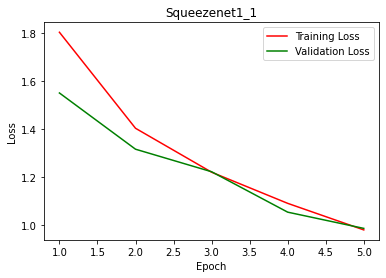

In [ ]:
# Loss Curve for Best Model
plt.plot(list(range(1,len(best_model_train_loss)+1)), best_model_train_loss, c='r', label='Training Loss')
plt.plot(list(range(1,len(best_model_val_loss)+1)), best_model_val_loss, c='g', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Squeezenet1_1')
plt.legend()
plt.show()

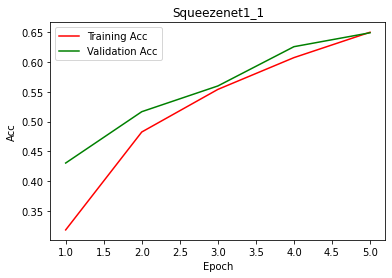

In [ ]:
# Accuracy Curve for Best Model
plt.plot(list(range(1,len(best_model_train_acc)+1)), best_model_train_acc, c='r', label='Training Acc')
plt.plot(list(range(1,len(best_model_val_acc)+1)), best_model_val_acc, c='g', label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Squeezenet1_1')
plt.legend()
plt.show()

In [ ]:
#test accuracy here
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)
y_true = []
y_pred = []
correct = 0
total = 0
# load best model during K-Fold
model = torch.load('squeezenet1_1_best.pt')
model.to(device)
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_true = y_true + labels.detach().numpy().tolist()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        y_pred = y_pred + predicted.to('cpu').detach().numpy().tolist()
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 64 %


In [ ]:
# Following code has been taken from pytorch forum
# and modified for getting number of parameters as well
# https://discuss.pytorch.org/t/finding-model-size/130275
param_size = 0
num_params = 0
for param in model.parameters():
  num_params += param.nelement()
  param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
  buffer_size += buffer.nelement() * buffer.element_size()
size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))
print('model params: {}'.format(num_params))

model size: 2.776MB
model params: 727626


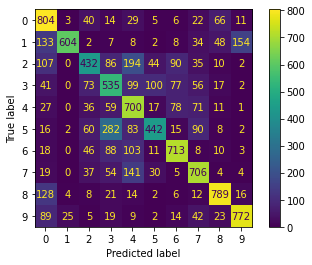

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot()

# LENET

In [ ]:
# Following Code has been taken from the following kaggle source
# https://www.kaggle.com/code/shreydan/lenet-5-cifar10-pytorch/notebook
class LeNet(nn.Module):
  def __init__(self, in_features=3, num_classes=10):
    super(LeNet, self).__init__()

    self.conv_block = nn.Sequential( nn.Conv2d(in_channels=in_features,
                                                  out_channels=6,
                                                  kernel_size=5,
                                                  stride=1),
                                        nn.Tanh(),
                                        nn.MaxPool2d(2,2),

                                        nn.Conv2d(in_channels=6,
                                                  out_channels=16,
                                                  kernel_size=5,
                                                  stride=1),
                                        nn.Tanh(),
                                        nn.MaxPool2d(2,2)
                                      )

    self.linear_block = nn.Sequential( nn.Linear(16*5*5, 120),
                                          nn.Tanh(),
                                          nn.Linear(120,84),
                                          nn.Tanh(),
                                          nn.Linear(84,10)
                                        )

  def forward(self, x):
    x = self.conv_block(x)
    x = torch.flatten(x,1)
    x = self.linear_block(x)
    return x

In [ ]:
transform_lenet = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

trainset_lenet = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_lenet)
testset_lenet = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_lenet)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_data = trainset_lenet
test_data = testset_lenet
kf = KFold(n_splits=num_splits)
best_model_acc_so_far = 0
for f, (train_index, val_index) in enumerate(kf.split(trainset)):
  start = time.time()
  print("#"*50+" Fold "+str(f)+" "+"#"*50)
  trainsubset = torch.utils.data.Subset(train_data, train_index)
  valsubset = torch.utils.data.Subset(train_data, val_index)

  model = LeNet()
  loss_fn = nn.CrossEntropyLoss()

  # Following Parameters are overridden in some folds
  # to simulate different training on model
  # to pick from best fold
  batch_size=32
  if f==0:
    lr = 0.0001
  elif f==1:
    lr = 0.0003
  elif f==2:
    lr = 0.001
  elif f==3:
    batch_size = 128
  elif f==4:
    batch_size = 256

  optimizer = optim.Adam(model.parameters(), lr=lr)

  trainloader = torch.utils.data.DataLoader(trainsubset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)
  valloader = torch.utils.data.DataLoader(valsubset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)

  epoch_train_loss = []
  epoch_train_acc = []
  epoch_val_loss = []
  epoch_val_acc = []
  model.to(device)
  for epoch in range(num_epochs):
    print("+"*50+" Epoch "+str(epoch)+" "+"+"*50)
    running_loss = 0.0
    running_corrects = 0
    model.train()
    for i, data in enumerate(trainloader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      _,preds = torch.max(outputs, 1)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()*inputs.size(0)
      running_corrects += torch.sum(labels==preds).item()
    train_loss = running_loss/len(trainloader.sampler)
    train_acc = running_corrects/len(trainloader.sampler)
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_acc)
    val_loss = 0
    val_acc = 0
    model.eval()
    with torch.no_grad():
      for i, data in enumerate(valloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs,labels)
        _,preds = torch.max(outputs, 1)
        val_loss += loss.item()*inputs.size(0)
        val_acc += torch.sum(labels==preds).item()
    val_loss = val_loss/len(valloader.sampler)
    val_acc = val_acc/len(valloader.sampler)
    epoch_val_loss.append(val_loss)
    epoch_val_acc.append(val_acc)
    print('Training: Loss: {} Accuracy: {}'.format(train_loss, train_acc))
    print('Vaidation: Loss: {} Accuracy: {}'.format(val_loss, val_acc))

  end = time.time()
  train_time = end-start
  val_loss = 0
  val_acc = 0
  model.eval()
  with torch.no_grad():
    for i, data in enumerate(valloader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs,labels)
      _,preds = torch.max(outputs, 1)
      val_loss += loss.item()*inputs.size(0)
      val_acc += torch.sum(labels==preds).item()
  val_loss = val_loss/len(valloader.sampler)
  val_acc = val_acc/len(valloader.sampler)
  print('Fold {} Validation Accuracy: {}'.format(f,val_acc))
  if best_model_acc_so_far < val_acc:
    best_model_acc_so_far = val_acc
    best_model_train_loss = epoch_train_loss
    best_model_train_acc = epoch_train_acc
    best_model_val_loss = epoch_val_loss
    best_model_val_acc = epoch_val_acc
    best_model_fold = f
    best_model_train_time = train_time
    torch.save(model, 'lenet_best.pt')

################################################## Fold 0 ##################################################
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 0 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 1.8479650506973266 Accuracy: 0.34165
Vaidation: Loss: 1.6487787826538085 Accuracy: 0.4118
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 1 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 1.5484607933998107 Accuracy: 0.44255
Vaidation: Loss: 1.4772567150115967 Accuracy: 0.4653
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 2 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 1.4344506278514861 Accuracy: 0.479975
Vaidation: Loss: 1.3976408929824828 Accuracy: 0.4901
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 3 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 1.3716262974262237 Accuracy: 0.504325
Vaidation: Loss: 1.3572826011657715 Accuracy: 0.506
++++++++++++++++++++++++++

In [ ]:
print("Best Fold: ",best_model_fold)
print("Best Model Val Accuracy: ",best_model_acc_so_far)
print("Best Model Train Time in seconds: ",best_model_train_time)

Best Fold:  2
Best Model Val Accuracy:  0.6084
Best Model Train Time in seconds:  91.62630081176758


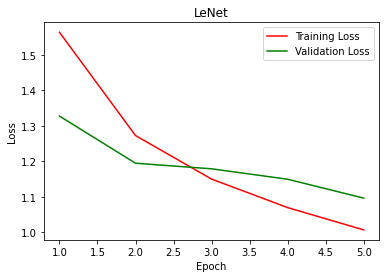

In [ ]:
# Loss Curve for Best Model
plt.plot(list(range(1,len(best_model_train_loss)+1)), best_model_train_loss, c='r', label='Training Loss')
plt.plot(list(range(1,len(best_model_val_loss)+1)), best_model_val_loss, c='g', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LeNet')
plt.legend()
plt.show()

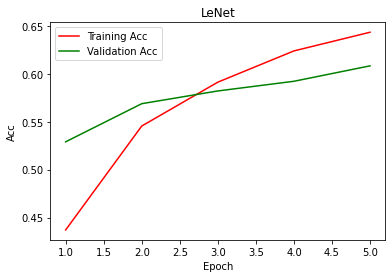

In [ ]:
# Accuracy Curve for Best Model
plt.plot(list(range(1,len(best_model_train_acc)+1)), best_model_train_acc, c='r', label='Training Acc')
plt.plot(list(range(1,len(best_model_val_acc)+1)), best_model_val_acc, c='g', label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('LeNet')
plt.legend()
plt.show()

In [ ]:
#test accuracy here
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)
y_true = []
y_pred = []
correct = 0
total = 0
# load best model during K-Fold
model = torch.load('lenet_best.pt')
model.to(device)
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_true = y_true + labels.detach().numpy().tolist()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        y_pred = y_pred + predicted.to('cpu').detach().numpy().tolist()
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %


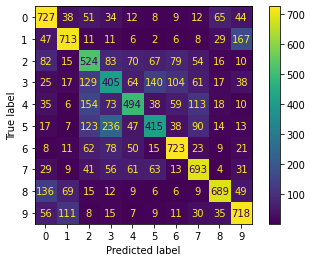

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
# Following code has been taken from pytorch forum
# and modified for getting number of parameters as well
# https://discuss.pytorch.org/t/finding-model-size/130275
param_size = 0
num_params = 0
for param in model.parameters():
  num_params += param.nelement()
  param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
  buffer_size += buffer.nelement() * buffer.element_size()
size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))
print('model params: {}'.format(num_params))

model size: 0.237MB
model params: 62006


## Summary for the Section I

We trained following three models for 5 Folds and 5 epochs

Model Name | Training Time | Model Size | Parameters | Validation Accuracy | Testing Accuracy
---|---|---|---|---|---
Mobilenet V3 small |601.4s|5.876MB|1528106|78.6%| 78%
Squeezenet1_1 |573.5s| 2.776MB|727626|64.95%|64%
LeNet |91.6s|0.237MB|62006|60.84%|61%


Out of the above models, we see mobilenet_v3_small performed the best. We will choose this model for hypothesis testing




# Section 2:


# Hypothesis One:
1. Increase/decrease the model size/complexity will improve performance (justify) (test) (yes/no) (explain)

We have our best mobile net v3 small model trained on data for the fold indexed at 2, i.e., 3rd Fold.

Lets try mobile net v3 large for same number of epochs and see if we can get better performance for the same fold

In [ ]:
best_fold_smaller_model = 2

In [ ]:
train_data = trainset
test_data = testset
kf = KFold(n_splits=num_splits)
best_model_acc_so_far = 0
for f, (train_index, val_index) in enumerate(kf.split(trainset)):
  if f!= best_fold_smaller_model:
    print('Skipping Fold {}'.format(f))
    continue
  start = time.time()
  print("#"*50+" Fold "+str(f)+" "+"#"*50)
  trainsubset = torch.utils.data.Subset(train_data, train_index)
  valsubset = torch.utils.data.Subset(train_data, val_index)

  model = models.mobilenet_v3_large(weights=None, num_classes=num_classes)
  loss_fn = nn.CrossEntropyLoss()

  # Following Parameters are overridden in some folds
  # to simulate different training on model
  # to pick from best fold
  batch_size=32
  if f==0:
    lr = 0.0001
  elif f==1:
    lr = 0.0003
  elif f==2:
    lr = 0.001
  elif f==3:
    batch_size = 128
  elif f==4:
    batch_size = 256

  optimizer = optim.Adam(model.parameters(), lr=lr)

  trainloader = torch.utils.data.DataLoader(trainsubset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
  valloader = torch.utils.data.DataLoader(valsubset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

  epoch_train_loss = []
  epoch_train_acc = []
  epoch_val_loss = []
  epoch_val_acc = []
  model.to(device)
  for epoch in range(num_epochs):
    print("+"*50+" Epoch "+str(epoch)+" "+"+"*50)
    running_loss = 0.0
    running_corrects = 0
    model.train()
    for i, data in enumerate(trainloader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      _,preds = torch.max(outputs, 1)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()*inputs.size(0)
      running_corrects += torch.sum(labels==preds).item()
    train_loss = running_loss/len(trainloader.sampler)
    train_acc = running_corrects/len(trainloader.sampler)
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_acc)
    val_loss = 0
    val_acc = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(valloader):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = loss_fn(outputs,labels)
          _,preds = torch.max(outputs, 1)
          val_loss += loss.item()*inputs.size(0)
          val_acc += torch.sum(labels==preds).item()

        val_loss = val_loss/len(valloader.sampler)
        val_acc = val_acc/len(valloader.sampler)
        epoch_val_loss.append(val_loss)
        epoch_val_acc.append(val_acc)
    print('Training: Loss: {} Accuracy: {}'.format(train_loss, train_acc))
    print('Vaidation: Loss: {} Accuracy: {}'.format(val_loss, val_acc))

  end = time.time()
  train_time = end-start
  val_loss = 0
  val_acc = 0
  model.eval()
  with torch.no_grad():
    for i, data in enumerate(valloader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs,labels)
      _,preds = torch.max(outputs, 1)
      val_loss += loss.item()*inputs.size(0)
      val_acc += torch.sum(labels==preds).item()
    val_loss = val_loss/len(valloader.sampler)
    val_acc = val_acc/len(valloader.sampler)
  print('Fold {} Validation Accuracy: {}'.format(f,val_acc))
  if best_model_acc_so_far < val_acc:
    best_model_acc_so_far = val_acc
    best_model_train_loss = epoch_train_loss
    best_model_train_acc = epoch_train_acc
    best_model_val_loss = epoch_val_loss
    best_model_val_acc = epoch_val_acc
    best_model_fold = f
    best_model_train_time = train_time
    torch.save(model, 'mobilenetv3_large_best.pt')

Skipping Fold 0
Skipping Fold 1
################################################## Fold 2 ##################################################
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 0 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 1.5047522110462188 Accuracy: 0.4389
Vaidation: Loss: 1.4240283325195313 Accuracy: 0.5215
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 1 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 1.0114088802337646 Accuracy: 0.640375
Vaidation: Loss: 0.8874959707260132 Accuracy: 0.6868
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 2 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 0.7696910098791122 Accuracy: 0.731675
Vaidation: Loss: 0.7040021182060242 Accuracy: 0.7524
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 3 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 0.6221886621594429 Accuracy: 0.7834
Vaidation: Loss: 0.6552888179779053 Accuracy: 0.

In [ ]:
print("Best Fold: ",best_model_fold)
print("Best Model Val Accuracy: ",best_model_acc_so_far)
print("Best Model Train Time in seconds: ",best_model_train_time)

Best Fold:  2
Best Model Val Accuracy:  0.7641
Best Model Train Time in seconds:  775.5999491214752


In [ ]:
#test accuracy here
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)
y_true = []
y_pred = []
correct = 0
total = 0
# load best model during K-Fold
model = torch.load('mobilenetv3_large_best.pt')
model.to(device)
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_true = y_true + labels.detach().numpy().tolist()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        y_pred = y_pred + predicted.to('cpu').detach().numpy().tolist()
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 76 %


# Observation

1. Increase/decrease the model size/complexity will improve performance (justify) (test) (yes/no) (explain)

No, We see that training on same data as the smaller model for same hyperparameters and same number of epochs did not give us higher accuracy.

```Old Best Model Acc: 78%```

```Hypothesis Model Acc: 76%```

On the other hand our training time has increased to 775 seconds from previous 601 seconds.

# Hypothesis Two
2. Increase/decrease the batch_size (justify) (test) (yes/no) (explain)

Our best model was trained with batch_size = 32. Lets try to double the batch_size = 64 and try to retrain for similar fold and skip other folds and see the change

In [ ]:
best_fold_smaller_model

2

In [ ]:
train_data = trainset
test_data = testset
kf = KFold(n_splits=num_splits)
best_model_acc_so_far = 0
for f, (train_index, val_index) in enumerate(kf.split(trainset)):
  if f!= best_fold_smaller_model:
    print('Skipping Fold {}'.format(f))
    continue
  start = time.time()
  print("#"*50+" Fold "+str(f)+" "+"#"*50)
  trainsubset = torch.utils.data.Subset(train_data, train_index)
  valsubset = torch.utils.data.Subset(train_data, val_index)

  model = models.mobilenet_v3_small(weights=None, num_classes=num_classes)
  loss_fn = nn.CrossEntropyLoss()

  # Following Parameters are overridden in some folds
  # to simulate different training on model
  # to pick from best fold
  batch_size=32
  if f==0:
    lr = 0.0001
  elif f==1:
    lr = 0.0003
  elif f==2:
    lr = 0.001
  elif f==3:
    batch_size = 128
  elif f==4:
    batch_size = 256

  # Overridding batch size for this hypothesis
  # doubling the batch
  batch_size = 64

  optimizer = optim.Adam(model.parameters(), lr=lr)

  trainloader = torch.utils.data.DataLoader(trainsubset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
  valloader = torch.utils.data.DataLoader(valsubset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

  epoch_train_loss = []
  epoch_train_acc = []
  epoch_val_loss = []
  epoch_val_acc = []
  model.to(device)
  for epoch in range(num_epochs):
    print("+"*50+" Epoch "+str(epoch)+" "+"+"*50)
    running_loss = 0.0
    running_corrects = 0
    model.train()
    for i, data in enumerate(trainloader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      _,preds = torch.max(outputs, 1)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()*inputs.size(0)
      running_corrects += torch.sum(labels==preds).item()
    train_loss = running_loss/len(trainloader.sampler)
    train_acc = running_corrects/len(trainloader.sampler)
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_acc)
    val_loss = 0
    val_acc = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(valloader):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = loss_fn(outputs,labels)
          _,preds = torch.max(outputs, 1)
          val_loss += loss.item()*inputs.size(0)
          val_acc += torch.sum(labels==preds).item()

        val_loss = val_loss/len(valloader.sampler)
        val_acc = val_acc/len(valloader.sampler)
        epoch_val_loss.append(val_loss)
        epoch_val_acc.append(val_acc)
    print('Training: Loss: {} Accuracy: {}'.format(train_loss, train_acc))
    print('Vaidation: Loss: {} Accuracy: {}'.format(val_loss, val_acc))

  end = time.time()
  train_time = end-start
  val_loss = 0
  val_acc = 0
  model.eval()
  with torch.no_grad():
    for i, data in enumerate(valloader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs,labels)
      _,preds = torch.max(outputs, 1)
      val_loss += loss.item()*inputs.size(0)
      val_acc += torch.sum(labels==preds).item()
    val_loss = val_loss/len(valloader.sampler)
    val_acc = val_acc/len(valloader.sampler)
  print('Fold {} Validation Accuracy: {}'.format(f,val_acc))
  if best_model_acc_so_far < val_acc:
    best_model_acc_so_far = val_acc
    best_model_train_loss = epoch_train_loss
    best_model_train_acc = epoch_train_acc
    best_model_val_loss = epoch_val_loss
    best_model_val_acc = epoch_val_acc
    best_model_fold = f
    best_model_train_time = train_time
    torch.save(model, 'mobilenetv3_small_best_hypo2.pt')

Skipping Fold 0
Skipping Fold 1
################################################## Fold 2 ##################################################
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 0 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 1.4100641324043275 Accuracy: 0.4759
Vaidation: Loss: 1.453001802635193 Accuracy: 0.5013
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 1 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 0.9409288767814636 Accuracy: 0.665925
Vaidation: Loss: 0.9059577175140381 Accuracy: 0.6898
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 2 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 0.732121358013153 Accuracy: 0.7466
Vaidation: Loss: 0.9425695766448975 Accuracy: 0.6927
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 3 ++++++++++++++++++++++++++++++++++++++++++++++++++
Training: Loss: 0.5999351192474365 Accuracy: 0.79095
Vaidation: Loss: 0.7543529253005982 Accuracy: 0.738

In [ ]:
print("Best Fold: ",best_model_fold)
print("Best Model Val Accuracy: ",best_model_acc_so_far)
print("Best Model Train Time in seconds: ",best_model_train_time)

Best Fold:  2
Best Model Val Accuracy:  0.7885
Best Model Train Time in seconds:  448.591899394989


In [ ]:
#test accuracy here
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)
y_true = []
y_pred = []
correct = 0
total = 0
# load best model during K-Fold
model = torch.load('mobilenetv3_small_best_hypo2.pt')
model.to(device)
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_true = y_true + labels.detach().numpy().tolist()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        y_pred = y_pred + predicted.to('cpu').detach().numpy().tolist()
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 78 %


# Observation
2. Increase/decrease the batch_size (justify) (test) (yes/no) (explain)

We see that training on higher batch than the previous training and same number of epochs did not affect accuracy but had better training time

```Old Best Model Acc: 78%```

```Hypothesis Model Acc: 78%```

On the other hand our training time has **decreased to 448 seconds** from previous 601 seconds.

# Hypothesis 3
3. Decrease the number of iterations in one epoch (justify) (test) (yes/no) (explain)
[Custom Hypothesis, inspired from point 3 part 2 of the assignment ]


Let's try using 50% iterations for one epoch and train the model

In [ ]:
train_data = trainset
test_data = testset
kf = KFold(n_splits=num_splits)
best_model_acc_so_far = 0
for f, (train_index, val_index) in enumerate(kf.split(trainset)):
  if f!= best_fold_smaller_model:
    print('Skipping Fold {}'.format(f))
    continue
  start = time.time()
  print("#"*50+" Fold "+str(f)+" "+"#"*50)
  trainsubset = torch.utils.data.Subset(train_data, train_index)
  valsubset = torch.utils.data.Subset(train_data, val_index)

  model = models.mobilenet_v3_small(weights=None, num_classes=num_classes)
  loss_fn = nn.CrossEntropyLoss()

  # Following Parameters are overridden in some folds
  # to simulate different training on model
  # to pick from best fold
  batch_size=32
  if f==0:
    lr = 0.0001
  elif f==1:
    lr = 0.0003
  elif f==2:
    lr = 0.001
  elif f==3:
    batch_size = 128
  elif f==4:
    batch_size = 256

  optimizer = optim.Adam(model.parameters(), lr=lr)

  trainloader = torch.utils.data.DataLoader(trainsubset, batch_size=batch_size,shuffle=True, num_workers=2)
  valloader = torch.utils.data.DataLoader(valsubset, batch_size=batch_size,shuffle=True, num_workers=2)

  epoch_train_loss = []
  epoch_train_acc = []
  epoch_val_loss = []
  epoch_val_acc = []
  model.to(device)



  for epoch in range(num_epochs):
    print("+"*50+" Epoch "+str(epoch)+" "+"+"*50)
    running_loss = 0.0
    running_corrects = 0
    model.train()

    # following peice of code tests the hypothesis by
    # training on 50% of iterations
    len_overall = len(trainloader.sampler)/2
    iter = 0
    flag = False
    l = 0
    for i, data in enumerate(trainloader):
      inputs, labels = data
      iter += inputs.size(0)
      if iter>=len_overall:
        if not flag:
          l = iter
          print("Skipping Rest of the Training Data")
        flag = True
        continue
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      _,preds = torch.max(outputs, 1)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()*inputs.size(0)
      running_corrects += torch.sum(labels==preds).item()
    train_loss = running_loss/l
    train_acc = running_corrects/l
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_acc)
    val_loss = 0
    val_acc = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(valloader):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = loss_fn(outputs,labels)
          _,preds = torch.max(outputs, 1)
          val_loss += loss.item()*inputs.size(0)
          val_acc += torch.sum(labels==preds).item()

        val_loss = val_loss/len(valloader.sampler)
        val_acc = val_acc/len(valloader.sampler)
        epoch_val_loss.append(val_loss)
        epoch_val_acc.append(val_acc)
    print('Training: Loss: {} Accuracy: {}'.format(train_loss, train_acc))
    print('Vaidation: Loss: {} Accuracy: {}'.format(val_loss, val_acc))

  end = time.time()
  train_time = end-start
  val_loss = 0
  val_acc = 0
  model.eval()
  with torch.no_grad():
    for i, data in enumerate(valloader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs,labels)
      _,preds = torch.max(outputs, 1)
      val_loss += loss.item()*inputs.size(0)
      val_acc += torch.sum(labels==preds).item()
    val_loss = val_loss/len(valloader.sampler)
    val_acc = val_acc/len(valloader.sampler)
  print('Fold {} Validation Accuracy: {}'.format(f,val_acc))
  if best_model_acc_so_far < val_acc:
    best_model_acc_so_far = val_acc
    best_model_train_loss = epoch_train_loss
    best_model_train_acc = epoch_train_acc
    best_model_val_loss = epoch_val_loss
    best_model_val_acc = epoch_val_acc
    best_model_fold = f
    best_model_train_time = train_time
    torch.save(model, 'mobilenetv3_small_best_hypo3.pt')

Skipping Fold 0
Skipping Fold 1
################################################## Fold 2 ##################################################
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 0 ++++++++++++++++++++++++++++++++++++++++++++++++++
Skipping Rest of the Training Data
Training: Loss: 1.6439093606948854 Accuracy: 0.3823
Vaidation: Loss: 1.625067961502075 Accuracy: 0.4365
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 1 ++++++++++++++++++++++++++++++++++++++++++++++++++
Skipping Rest of the Training Data
Training: Loss: 1.1947297830581665 Accuracy: 0.56965
Vaidation: Loss: 1.2180832763671876 Accuracy: 0.5793
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 2 ++++++++++++++++++++++++++++++++++++++++++++++++++
Skipping Rest of the Training Data
Training: Loss: 0.9708983527183532 Accuracy: 0.65425
Vaidation: Loss: 1.2708755518913268 Accuracy: 0.5928
++++++++++++++++++++++++++++++++++++++++++++++++++ Epoch 3 +++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
print("Best Fold: ",best_model_fold)
print("Best Model Val Accuracy: ",best_model_acc_so_far)
print("Best Model Train Time in seconds: ",best_model_train_time)

Best Fold:  2
Best Model Val Accuracy:  0.6581
Best Model Train Time in seconds:  462.8616349697113


In [ ]:
#test accuracy here
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)
y_true = []
y_pred = []
correct = 0
total = 0
# load best model during K-Fold
model = torch.load('mobilenetv3_small_best_hypo3.pt')
model.to(device)
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_true = y_true + labels.detach().numpy().tolist()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        y_pred = y_pred + predicted.to('cpu').detach().numpy().tolist()
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 67 %


# Observation
3. Decrease the number of iterations in one epoch (justify) (test) (yes/no) (explain)
[Custom Hypothesis, inspired from point 3 part 2 of the assignment ]



We see that training on less number of iterations than the previous training and same number of epochs  give us lower accuracy.

```Old Best Model Acc: 78%```

```Hypothesis Model Acc: 67%```

On the other hand our training time has **decreased to 462 seconds** from previous 601 seconds.